# California Housing Price

This is a modified version of the example code in the course.

__Note__: To fetch the data I had to use a VPN:

```sh
export http_proxy=... https_proxy=...
ource /path/to/venv
# Done!
```

In [2]:
import os
import shutil
import sys

assert sys.version_info >= (3, 8), "This project requires Python 3.8+"

from packaging import version
import torch

assert version.parse(torch.__version__) >= version.parse(
    "2.1.2"
), "This project requires pytorch 2.1.1 or above!"

In [3]:
# src: https://youtu.be/lS0vvIWiahU
try:
    import google.colab

    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available
device = (
    "mps" if torch.backends.mps.is_built() else "cuda" if torch.backends.cuda.is_built() else "cpu"
)

print(f"Using device: {device}")

Note: not using Google CoLab
Using device: mps


In [4]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"

import matplotlib.pyplot as plt

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchvision import transforms
from tqdm import tqdm

## Preparing the Data

In [6]:
data = fetch_california_housing(data_home="./data", download_if_missing=True)
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
# 1. Adapt (fit) and 2. transform the data to scaled values
X_train = scaler.fit_transform(X_train)
# Only transform using the scaler fitted with the train data
# This way we leak no information about test data to the training process
X_test = scaler.transform(X_test)

In [7]:
type(data)

sklearn.utils._bunch.Bunch

In [8]:
print("Type of X:", type(X), "\tType of y:", type(y))
print("Shape of X:", X.shape, "\t\t\tShape of y:", y.shape)

Type of X: <class 'numpy.ndarray'> 	Type of y: <class 'numpy.ndarray'>
Shape of X: (20640, 8) 			Shape of y: (20640,)


In [9]:
print("Shape of X_train:", X_train.shape, "\t\tShape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape, "\t\tShape of y_test:", y_test.shape)

Shape of X_train: (16512, 8) 		Shape of y_train: (16512,)
Shape of X_test: (4128, 8) 		Shape of y_test: (4128,)


In [12]:
# Create a custom PyTorch dataset
class CaliforniaHousingDataset(Dataset):
    def __init__(self, features, targets, transform=None, target_transform=None):
        self.features = features
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self) -> int:
        return len(self.features)

    def __getitem__(self, index) -> tuple:
        x = self.features[index]
        y = self.targets[index]
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x, y

In [13]:
# Apply a user-defined lambda as a transform.
# class Lambda(lambd: (x: Any) -> Tensor)
toTensorTransform = transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32))

type(toTensorTransform)

torchvision.transforms.transforms.Lambda

In [14]:
# Create instances of the custom dataset
train_dataset = CaliforniaHousingDataset(
    X_train,
    y_train,
    transform=toTensorTransform,
    target_transform=transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0)),
)
# .unsqueeze(dim=0): label (scalar) () tensor -> label (1,) tensor
test_dataset = CaliforniaHousingDataset(
    X_test,
    y_test,
    transform=toTensorTransform,
    target_transform=transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0)),
)

# Create PyTorch data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [15]:
data, target = next(iter(train_dataset))
print(target.size())
# Because of .unsqeeze(0), labels are (1,) tensor,
# and can be compared against the output of the model, which is of the same shape.

torch.Size([1])


## Building your model

In [17]:
# Implementation of linear model
class MyLinear(nn.Module):
    r"""
    Applies a linear transformation to the incoming data: `y = xA^T + b`
    """

    def __init__(
        self, in_f: int, out_f: int, bias: bool = True, device=None, dtype=None, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        factory_kwargs = {"device": device, "dtype": dtype}
        self.bias = bias
        self.w: torch.Tensor = nn.parameter.Parameter(torch.empty(out_f, in_f), **factory_kwargs)
        if bias:
            self.b = nn.parameter.Parameter(torch.empty(out_f), **factory_kwargs)
        self.reset_params()  # initialization paramters

    def reset_params(self):
        nn.init.kaiming_normal_(self.w, nonlinearity="relu")
        if self.bias:
            nn.init.constant_(self.b, 0)

    def forward(self, x):
        return F.linear(x, self.w, self.b)

In [18]:
def build_model(input_size, hidden_size, output_size):
    model = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size),
    )
    return model

## Train & Test

In [19]:
num_epochs = 30

model = build_model(8, 200, 1)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [21]:
train_history = []
validation_history = []

for epoch in range(num_epochs):
    model.train()
    losses = []

    with tqdm(train_loader, leave=False) as bar:
        bar.set_description(f"[Epoch: {epoch + 1}/{num_epochs}]")

        for batch_idx, (data, target) in enumerate(bar):
            data = data.to(device)
            target = target.to(device)

            output = model(data)

            loss = criterion(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            bar.set_postfix(avg_epoch_loss=f"{sum(losses)/len(losses):.4f}")
    train_history.append(sum(losses) / len(losses))

    model.eval()
    running_testloss = 0.0

    with torch.no_grad():
        for i, (test_data, test_label) in enumerate(test_loader):
            test_data = test_data.to(device)
            test_label = test_label.to(device)
            test_output = model(test_data)
            vloss = criterion(test_output, test_label)
            running_testloss += vloss.item()
        avg_vloss = running_testloss / (i + 1)
        validation_history.append(avg_vloss)
        if epoch % 10 == 9:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}]: loss train: {sum(losses)/len(losses):.3f}, validation: {avg_vloss:.3f}"
            )

Epoch [10/30]: loss train: 0.303, validation: 0.304


Epoch [20/30]: loss train: 0.270, validation: 0.295


Epoch [30/30]: loss train: 0.258, validation: 0.275


In [25]:
with torch.no_grad():
    data, target = next(iter(test_loader))
    data = data.to(device=device)
    target = target.to(device=device)
    y_pred = model(data[:10])
    print("y_true", target[:10])
    print("y_pred", y_pred)

y_true tensor([[0.4770],
        [0.4580],
        [5.0000],
        [2.1860],
        [2.7800],
        [1.5870],
        [1.9820],
        [1.5750],
        [3.4000],
        [4.4660]], device='mps:0')
y_pred tensor([[0.6008],
        [1.0987],
        [5.0130],
        [2.5398],
        [3.0653],
        [1.5361],
        [2.3937],
        [1.5995],
        [2.3767],
        [4.5635]], device='mps:0')


In [26]:
k = 4
num_val_samples = len(train_dataset) // k
num_epochs = 100

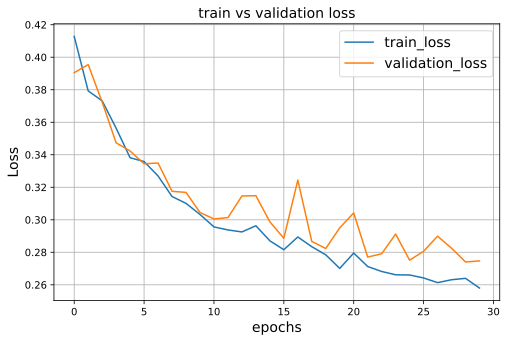

In [29]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(train_history, label="train_loss")
ax.plot(validation_history, label="validation_loss")
ax.set_title("train vs validation loss")
ax.set_ylabel("Loss")
ax.set_xlabel("epochs")
ax.grid()
ax.legend(loc="upper right")
plt.show()